# 200722 Find intra-taxon distances

In [1]:
using GZip
using ProgressMeter
using DataFrames
using StatsBase
using CSV
using CategoricalArrays
using JSON
using Serialization
using VPTrees

In [2]:
using Midas
using Midas.Distances
using Midas.SignatureFiles

In [3]:
const metric = jaccard_dist_sorted

jaccard_dist_sorted (generic function with 1 method)

## Func defs

In [4]:
findclass(a::CategoricalArray, cls::CategoricalValue) = findall(==(cls), a)
findclass(a::CategoricalArray, i::Integer) = findclass(a, a.pool[i])

findclass (generic function with 2 methods)

In [5]:
skip_label(labels::CategoricalArray, li::Int) = i -> labels.refs[i] == li

skip_label (generic function with 1 method)

## File paths

In [6]:
taxonomy_file = "/Users/student/notebooks/midas/midas-notebooks-2019/build-v1-database/out/3-curated-taxonomy-assignments.csv"
signature_file_name = "/Users/student/projects/midas/data/2019_20/refseq_curated_1.1beta_200604.midas-signatures.gz"
;

In [7]:
tmpdir = "tmp/"
!isdir(tmpdir) && mkdir(tmpdir);

In [8]:
outdir = "../../data/processed/200722-detect-overlaps/"
isdir(outdir) || mkdir(outdir);

## Load taxonomy

In [9]:
taxdf = DataFrame(CSV.File(taxonomy_file));

In [10]:
sig_genera = categorical(taxdf[!, :genus])
genera = levels(sig_genera)
ngenera = length(genera)

sig_species = categorical([(row[:genus], row[:species]) for row in eachrow(taxdf)])
species = levels(sig_species)
nspecies = length(species)

ngenera, nspecies

(419, 1438)

In [11]:
genus_counts = counts(sig_genera.refs)
species_counts = counts(sig_species.refs)
;

In [12]:
genome_accs = [last(split(k, "/")) for k in taxdf[!, :key]];

## Load signatures

In [13]:
sigfile = SignatureFile(GZip.open(signature_file_name))

SignatureFile{UInt32,GZipStream} with 50752 elements

In [14]:
metadata = SignatureFiles._read_metadata(sigfile.stream, sigfile.header.o_metadata...)
JSON.print(metadata, 2)

{
  "date_created": "2020-06-04",
  "genome_set": {
    "key": "midas/assembly/curated",
    "name": "refseq_curated_2020",
    "meta": {
      "date_created": "2020-05-26",
      "parent": {
        "key": "midas/assembly/curated",
        "key_version": "0.9"
      }
    },
    "description": "Created 2020-05-26 by filtering version 0.9 by inclusion in refseq/assembly/all 1.1",
    "key_version": "1.1"
  },
  "kmer_spec": {
    "k": 11,
    "prefix": "ATGAC"
  },
  "description": "Signatures for version 1.1 of curated genome set"
}


In [15]:
# Should both be sorted:
@assert sigfile.ids == taxdf[:, :key]

In [16]:
@time sigs = SignatureArray(sigfile);

 86.662936 seconds (53.71 k allocations: 1.355 GiB, 0.01% gc time)


In [17]:
nsigs = length(sigs)

50752

### Build tree

In [ ]:
@time tree = VPTree(collect(sigs), metric);

## Intra-species distances

In [ ]:
species_tmpfile = joinpath(tmpdir, "intra-species-dists.jld")

if isfile(species_tmpfile)
    species_dists = deserialize(species_tmpfile)
else
    species_dists = Dict{Int, Tuple{Float64, Int, Int}}()
end

In [ ]:
prog = Progress(nsigs, start=sum(species_counts[i] for i in keys(species_dists)))

for si in 1:nspecies
    haskey(species_dists, si) && continue
    
    sp_inds = findclass(sig_species, si)
    skipf = skip_label(sig_species, si)

    best = Ref((Inf, 0, 0))

    for i in sp_inds
        j = find_nearest(tree, sigs[i], 1, skipf) |> only
        d = metric(sigs[i], sigs[j])
        d < best[][1] && (best[] = (d, i, j))
        next!(prog)
    end

    species_dists[si] = best[]
end

In [ ]:
serialize(species_tmpfile, species_dists)

In [51]:
function countsig!(totals::AbstractVector{T}, sig, w::T=one(T)) where T
    for i in sig
        @inbounds totals[i + 1] += w
    end
end


countsig! (generic function with 3 methods)

In [33]:
cnts = zeros(UInt16, 4^11);

In [23]:
maximum(first(sigs))

0x003ff50f

In [41]:
@showprogress for s in sigs
    countsig!(cnts, s)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [54]:
fracs = cnts ./ nsigs

4194304-element Array{Float64,1}:
 0.009457755359394703
 0.0014383669609079445
 0.0010442938209331652
 0.0010442938209331652
 0.0014974779319041614
 0.0016551071878940732
 0.001832440100882724
 0.0008078499369482976
 0.00057140605296343
 0.004847099621689785
 0.00027585119798234555
 0.00015762925598991173
 0.003605769230769231
 ⋮
 0.0022659205548549812
 9.851828499369483e-5
 0.0001182219419924338
 0.0002364438839848676
 0.0006305170239596469
 0.00025614754098360657
 0.00019703656998738966
 0.0005517023959646911
 1.9703656998738966e-5
 0.00015762925598991173
 5.91109709962169e-5
 9.851828499369483e-5

In [60]:
function entropy(p)
    0 < p < 1 || return zero(p)
    q = 1 - p
    return -(q*log2(p) + p*log2(q))
end

entropy (generic function with 1 method)

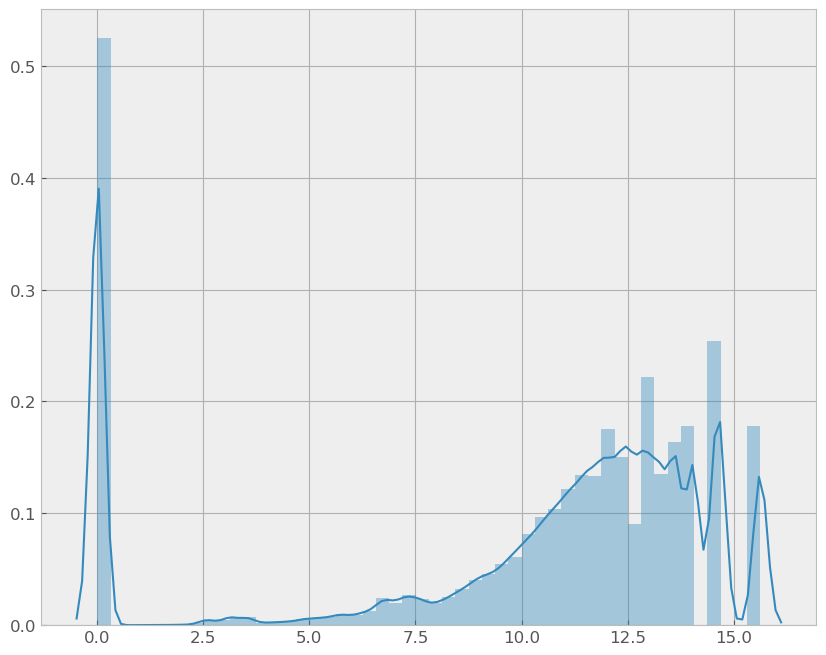

PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x1c0aa2320>

In [61]:
sns.distplot(entropy.(fracs))

In [44]:
using PyPlot, PyCall
sns = pyimport("seaborn")

PyObject <module 'seaborn' from '/Users/student/anaconda/envs/modeling/lib/python3.6/site-packages/seaborn/__init__.py'>

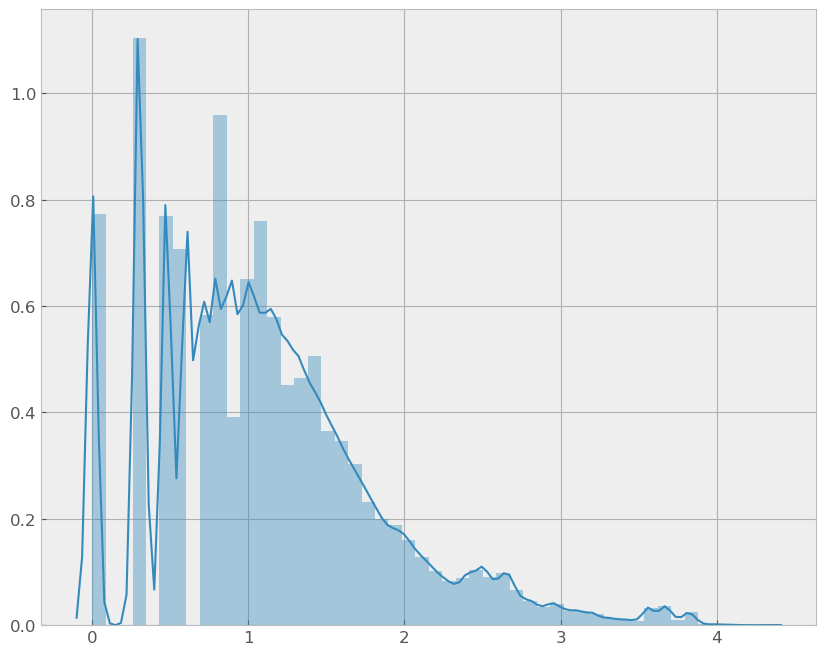

PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x1aff65c1d0>

In [49]:
sns.distplot([log10(c) for c in cnts if c > 0])

In [53]:
cnts_weighted = zeros(4^11)

for i in 1:nsigs
    si = sig_species.refs[i]
    w = sqrt(species_counts[si])
    countsig!(cnts_weighted, i, w)
end